# CV Passion Selector


## What is the program about?
A GenAI-powered assistant that takes a structured JSON CV (experience, projects, education, skills) and outputs recommended “passion domains” or career directions, based on:
- semantic matching,
- skills/interests inference,
- and structured reasoning.

## My plan (step-by-step):
1. User JSON - CV structured input;
2. Text Chunker - flattening experience, projects;
3. Embedding Generator (LLM) - storing in vector DB;
4. Vector Search over PassionDomain DB - listing of ~15 target domains;
5. Prompt Generator (few-shot) - formats examples + JSON schema;
6. LLM Inference - returns structured output and summary.

## Summary:
The CV Passion Selector is a GenAI-powered assistant designed to recommend personalized career directions based on a user's structured resume. The system processes JSON-formatted CV data (including experience, projects, and skills), encodes it using embedding models, and performs a semantic search over a curated set of 13 “passion domains.” Using a few-shot prompted LLM, it returns a structured recommendation that includes the best-fit domain, reasoning, confidence score, keyword matches, skill gaps, and actionable next steps. The project integrates ChromaDB for lightweight vector retrieval and Google Gemini for structured reasoning. This tool exemplifies how retrieval-augmented generation (RAG) pipelines can guide learners or professionals toward meaningful career paths by combining semantic understanding with explainable AI.

In [ ]:
# Only if you have not installed the required packages yet

# !pip install google-genai chromadb
# !pip install python-dotenv
# !pip install google-api-core
# !pip install pandas
# !pip install seaborn

  Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp313-cp313-macosx_10_13_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl (3.0 MB)
Using cached pyparsing-3.2.3

In [2]:
from google import genai
from google.genai import types
import pandas as pd
import seaborn as sns
import json

from IPython.display import Markdown

genai.__version__

'1.11.0'

In [3]:
import os
from dotenv import load_dotenv

load_dotenv(".env")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

print("✅ API key loaded!" if GOOGLE_API_KEY else "❌ Not loaded")

✅ API key loaded!


In [4]:
client = genai.Client(api_key=GOOGLE_API_KEY)

Customing Gemini embedding function with retry logic:

In [5]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from google.genai import types

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

class GeminiEmbeddingFunction(EmbeddingFunction):
    def __init__(self, document_mode=True):
        self.document_mode = document_mode

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        task_type = "retrieval_document" if self.document_mode else "retrieval_query"
        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(task_type=task_type),
        )
        return [e.values for e in response.embeddings]

Firstly, I want to define and describe the passion domain space (13):

In [6]:
passion_domains = [
    {
        "domain": "Climate Tech",
        "description": "Focuses on building technologies that mitigate climate change or support sustainability, such as clean energy, carbon tracking, and environmental monitoring tools.",
        "projects": [
            "solar panel optimizer",
            "emissions tracking platform",
            "climate policy simulator"
        ],
        "text": "Climate Tech. Focuses on building technologies that mitigate climate change or support sustainability, such as clean energy, carbon tracking, and environmental monitoring tools. Keywords: sustainability, renewable energy, carbon footprint, CO2, solar, climate dashboard, net zero, geospatial."
    },
    {
        "domain": "Creative AI",
        "description": "Combines artificial intelligence with art, music, design, or storytelling to build tools for generative creativity and interactive media.",
        "projects": [
            "AI art gallery",
            "interactive storybook generator",
            "music composition assistant"
        ],
        "text": "Creative AI. Combines artificial intelligence with art, music, design, or storytelling to build tools for generative creativity and interactive media. Keywords: generative art AI, music AI, GANs, creative tools, text-to-image, story generation, VQGAN, Stable Diffusion, DALL·E."
    },
    {
        "domain": "Data for Good",
        "description": "Applies data science and machine learning to social or humanitarian causes, helping NGOs, governments, or communities solve meaningful problems.",
        "projects": [
            "poverty map visualizer",
            "donation impact dashboard",
            "ML for disaster prediction"
        ],
        "text": "Data for Good. Applies data science and machine learning to social or humanitarian causes, helping NGOs, governments, or communities solve meaningful problems. Keywords: open data, nonprofits, UN SDGs, data visualization, social datasets, disaster response, public policy."
    },
    {
        "domain": "Social Impact Startups",
        "description": "Entrepreneurial ventures focused on solving real-world problems with a measurable social benefit — combining tech and mission.",
        "projects": [
            "affordable education platform",
            "mental health app",
            "accessible hiring tool"
        ],
        "text": "Social Impact Startups. Entrepreneurial ventures focused on solving real-world problems with a measurable social benefit — combining tech and mission. Keywords: founder, nonprofit, impact, ethical innovation, tech for good, grassroots, sustainability, community."
    },
    {
        "domain": "Health Tech",
        "description": "Builds software or AI solutions for healthcare, wellness, and medicine — from diagnosis tools to patient-facing apps.",
        "projects": [
            "symptom checker chatbot",
            "glucose tracker app",
            "AI-assisted X-ray classifier"
        ],
        "text": "Health Tech. Builds software or AI solutions for healthcare, wellness, and medicine — from diagnosis tools to patient-facing apps. Keywords: electronic health records, diagnostics, telemedicine, wearables, medical imaging, health tracker, HIPAA, genomics."
    },
    {
        "domain": "AI Researcher",
        "description": "Focuses on the theoretical and experimental development of artificial intelligence algorithms, models, and training methodologies.",
        "projects": [
            "custom transformer variant",
            "paper reproduction study",
            "pretraining experiments"
        ],
        "text": "AI Researcher. Focuses on the theoretical and experimental development of artificial intelligence algorithms, models, and training methodologies. Keywords: transformers, language models, LLMs, optimization, zero-shot, multi-modal, NeurIPS, arXiv."
    },
    {
        "domain": "FinTech",
        "description": "Applies AI and software to improve or disrupt financial services like banking, investing, fraud detection, or crypto systems.",
        "projects": [
            "transaction anomaly detector",
            "crypto portfolio tracker",
            "expense classifier"
        ],
        "text": "FinTech. Applies AI and software to improve or disrupt financial services like banking, investing, fraud detection, or crypto systems. Keywords: blockchain, fraud detection, trading bots, finances, risk scoring, robo-advisors, wallet, payments."
    },
    {
        "domain": "Education Technology",
        "description": "Creates intelligent educational platforms, tutoring systems, or adaptive learning tools for learners and educators.",
        "projects": [
            "adaptive quiz system",
            "AI math explainer",
            "learning analytics tool"
        ],
        "text": "Education Technology. Creates intelligent educational platforms, tutoring systems, or adaptive learning tools for learners and educators. Keywords: LMS, tutor bot, quiz generator, personalized learning, K-12, student dashboard, assessment, flashcards."
    },
    {
        "domain": "Civic Tech",
        "description": "Builds tools to improve public services, government transparency, or civic engagement — tech for democracy and participation.",
        "projects": [
            "city complaint heatmap",
            "public budget explainer",
            "polling place finder"
        ],
        "text": "Civic Tech. Builds tools to improve public services, government transparency, or civic engagement — tech for democracy and participation. Keywords: open government, census, public policy, urban data, transportation, voting, community tools, gov services."
    },
    {
        "domain": "CV Engineer",
        "description": "Specializes in building computer vision systems — detecting, segmenting, or tracking objects across images and video.",
        "projects": [
            "object tracker for drones",
            "real-time mask detection",
            "OCR document scanner"
        ],
        "text": "CV Engineer. Specializes in building computer vision systems — detecting, segmenting, or tracking objects across images and video. Keywords: YOLO, OpenCV, image classification, pose estimation, segmentation, detection, transformers for vision, face recognition."
    },
    {
        "domain": "Software Engineer",
        "description": "Generalist builder of software systems — backend, frontend, APIs, and infrastructure — solving problems across industries.",
        "projects": [
            "CRUD SaaS app",
            "REST API backend",
            "productivity automation tool"
        ],
        "text": "Software Engineer. Generalist builder of software systems — backend, frontend, APIs, and infrastructure — solving problems across industries. Keywords: full stack, APIs, unit tests, CI/CD, software architecture, design patterns, debugging, REST, microservices."
    },
    {
        "domain": "Frontend Developer",
        "description": "Focuses on building elegant, interactive user interfaces using web technologies like HTML, CSS, JavaScript, and modern frameworks.",
        "projects": [
            "portfolio site",
            "interactive dashboard",
            "design token system"
        ],
        "text": "Frontend Developer. Focuses on building elegant, interactive user interfaces using web technologies like HTML, CSS, JavaScript, and modern frameworks. Keywords: React, Vue, TypeScript, design systems, CSS, animations, UI/UX, tailwind, Web accessibility, JavaScript."
    },
    {
        "domain": "Backend Developer",
        "description": "Develops the logic, infrastructure, and databases behind web applications — enabling APIs, business logic, and scalable services.",
        "projects": [
            "task queue service",
            "user auth system",
            "API for a mobile app"
        ],
        "text": "Backend Developer. Develops the logic, infrastructure, and databases behind web applications — enabling APIs, business logic, and scalable services. Keywords: Django, Flask, Node.js, SQL, MongoDB, API design, authentication, Docker, serverless, load balancing."
    }
]

Then I prepare and embed them:

In [12]:
texts = [entry["text"] for entry in passion_domains]
ids = [entry["domain"] for entry in passion_domains]

metadatas = [
    {
        "domain": entry["domain"],
        "description": entry["description"],
        "projects": ", ".join(project for project in entry["projects"])
    }
    for entry in passion_domains
]

In [13]:
response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))

embeddings = [e.values for e in response.embeddings]

I used a function and implementation for plotting from codelab to see how they are related to each other:

In [14]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

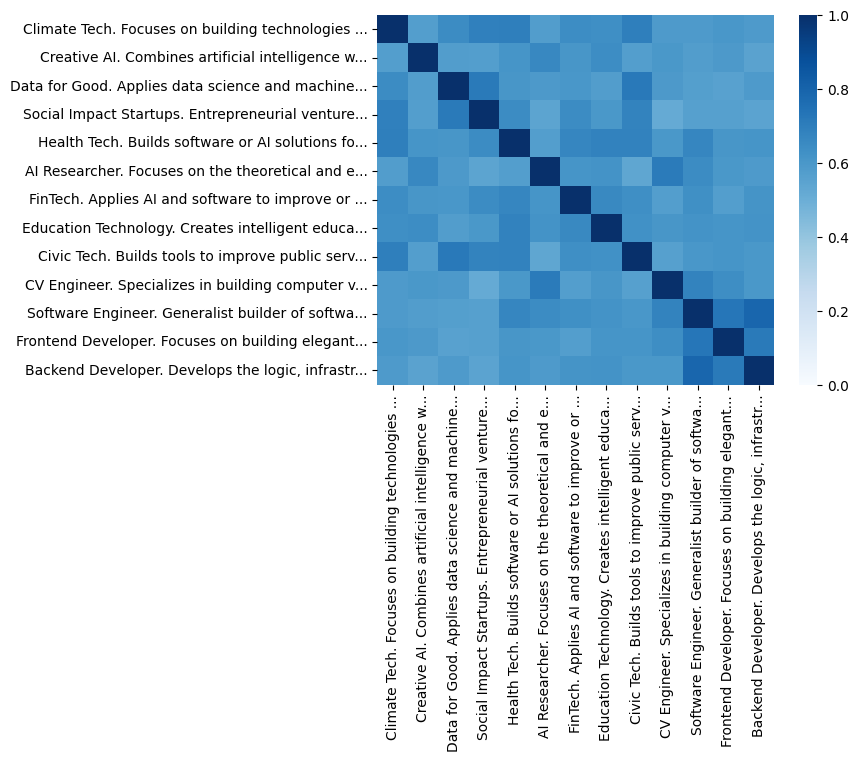

In [15]:
df = pd.DataFrame([e.values for e in response.embeddings], index=truncated_texts)
sim = df @ df.T
sns.heatmap(sim, vmin=0, vmax=1, cmap="Blues");

I store them to Chroma DB:

In [16]:
import chromadb
from chromadb.config import Settings

DB_NAME = "passion_space"
embed_fn = GeminiEmbeddingFunction(document_mode=True)

chroma_client = chromadb.Client(Settings())
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=texts, ids=ids, metadatas=metadatas)
print(f"Stored {db.count()} documents in Chroma collection '{DB_NAME}'")

Stored 13 documents in Chroma collection 'passion_space'


Now, I want to design an input format (JSON CV) and create an example:

In [17]:
JSON_unused_example_structure = {
  "experience": [...],
  "projects": [...],
  "education": [...],
  "skills": [...],
  "certifications": [...],
  "awards": [...]
}

The code defines a cv_to_text() function that transforms a structured CV JSON into a natural language summary by concatenating experience, projects, skills, certifications, awards, and education into readable text blocks. This flattened CV text is then passed into the Gemini embedding model (text-embedding-004) to generate a dense vector representation suitable for semantic search. The resulting embedding is queried against a vector database using ChromaDB to find the top matching passion domain (n_results=1). The response is serialized using json.dumps() for further use or LLM-based parsing:

In [19]:
def cv_to_text(cv_json: dict) -> str:
    parts = []

    # Experience
    for exp in cv_json.get("experience", []):
        parts.append(f"{exp['title']} at {exp['company']}: {exp['description']}")
        if 'technologies' in exp:
            parts.append(f"Technologies: {', '.join(exp['technologies'])}")
        if 'achievements' in exp:
            parts.append(f"Achievements: {', '.join(exp['achievements'])}")

    # Projects
    for proj in cv_json.get("projects", []):
        parts.append(f"Project: {proj['title']} — {proj['description']}")
        if 'technologies' in proj:
            parts.append(f"Tech stack: {', '.join(proj['technologies'])}")

    # Skills
    if 'skills' in cv_json:
        parts.append(f"Skills: {', '.join(cv_json['skills'])}")

    # Certifications
    for cert in cv_json.get("certifications", []):
        parts.append(f"Certification: {cert['title']} from {cert['issuer']}")

    # Awards
    for award in cv_json.get("awards", []):
        parts.append(f"Award: {award['title']} from {award['organization']}")

    # Education summary
    for edu in cv_json.get("education", []):
        parts.append(f"Studied {edu['degree']} at {edu['institution']}")
        if 'courses' in edu:
            parts.append(f"Courses: {', '.join(edu['courses'])}")

    return "\n".join(parts)

From the cell you can change example1_input on your own and see different results:

In [ ]:
example1_input = {
    "experience": [
    {
      "title": "Data Analyst Intern",
      "company": "FinTech Solutions",
      "location": "Remote",
      "start_date": "2023-06",
      "end_date": "2023-09",
      "description": "Cleaned transaction data, built dashboards to detect anomalies, collaborated with fraud team.",
      "technologies": ["SQL", "Python", "Looker"],
      "achievements": [
        "Reduced data cleaning time by 30%",
        "Detected 120+ fraud cases with automated scoring"
      ]
    }
  ],
    "projects": [
  {
    "title": "OpenClimate Dashboard",
    "description": "Built a React app to visualize CO₂ emissions from open datasets.",
    "technologies": ["React", "Chart.js", "Netlify"],
    "links": {
      "demo": "https://climate-dashboard",
      "github": "https://github.com/username/climate-dashboard"
    }
  }
],
    "education": [
  {
    "institution": "UCU",
    "degree": "BSc in Computer Science",
    "start_date": "2021-09",
    "end_date": "2025-06",
    "courses": ["Algorithms", "Databases", "ML", "Computer Vision"]
  }
],
    "skills": [
  "Python", "SQL", "React", "Git", "Pandas", "FastAPI", "Figma"
],
    "certifications": [
  {
    "title": "TensorFlow Developer Certificate",
    "issuer": "DeepLearning.AI",
    "date": "2023-02"
  }
],
"awards": [
  {
    "title": "2nd Place — AI Hackathon",
    "organization": "UCU",
    "date": "2023-11"
  }
],
    "language": [
        {
            "English": "B2",
            "Ukrainian": "Mother tongue",
            "Polish": "B2"
        }
    ]
}

In [20]:
cv_text = cv_to_text(example1_input)

cv_embedding = client.models.embed_content(
    model="models/text-embedding-004",
    contents=cv_text,
    config=types.EmbedContentConfig(task_type="retrieval_query")
).embeddings[0].values

In [21]:
results = db.query(
    query_embeddings=[cv_embedding],
    n_results=1
)

results = json.dumps(results, indent=2).replace("\n ", "")

And the output format should be structured like this:

In [23]:
example1_output = {
      "domain": "Data for Good",
      "reason": "User built a dashboard for nonprofit emissions tracking and used public datasets in past projects.",
      "example_path": "Data scientist for UN-backed open data team",
      "confidence_score": 0.92,
      "domain_keywords_matched": ["dashboard", "public data", "nonprofit"],
      "next_step": "Apply to Data4Good fellowships or volunteer with DataKind"
}

This section of the code defines a **few-shot prompt**, a powerful technique in prompt engineering where multiple example input-output pairs are provided to the model to guide its behavior.

The prompt begins with a clear instruction: “Parse a user's CV into valid JSON”, followed by two well-structured examples. Each example includes a vector search result (containing domain metadata, description, and distance) and a corresponding ideal JSON Response that captures the domain name, reasoning, confidence score, matched keywords, and suggested next step. By showing the model two diverse domain cases — “Data for Good” and “CV Engineer” — the prompt sets a strong precedent for how the model should analyze and format the next unseen CV input. This approach ensures that the model returns consistent, structured, and interpretable outputs that align with the expected schema (PassionSpace).

In [25]:
few_shot_prompt = """You are an assistant who helps people to find their job occupation based on their CV. Parse a user's CV into valid JSON:

EXAMPLE:
{ "ids": [   [     "Data for Good"   ] ], "embeddings": null, "documents": [   [     "Data for Good. Applies data science and machine learning to social or humanitarian causes, helping NGOs, governments, or communities solve meaningful problems. Keywords: open data, nonprofits, UN SDGs, data visualization, social datasets, disaster response, public policy."   ] ], "uris": null, "data": null, "metadatas": [   [     {       "description": "Applies data science and machine learning to social or humanitarian causes, helping NGOs, governments, or communities solve meaningful problems.",       "domain": "Data for Good",       "projects": "poverty map visualizer, donation impact dashboard, ML for disaster prediction"     }   ] ], "distances": [   [     0.7927830219268799   ] ], "included": [   "distances",   "documents",   "metadatas" ]
}
JSON Response:
```
{
  "domain": "Data for Good",
  "reason": "The user has worked on socially impactful machine learning applications such as a poverty map visualizer, a donation impact dashboard, and a disaster prediction system — showing a strong commitment to using technology for public benefit.",
  "example_path": "Data Scientist supporting NGO open-data initiatives",
  "confidence_score": 0.21,
  "domain_keywords_matched": ["data visualization", "public policy", "open data"],
  "next_step": "Join platforms like DataKind or Zindi to collaborate on social good projects, and consider studying the UN SDG framework to align future work with global impact goals."
}
```

EXAMPLE:
{ "ids": [   [     "CV Engineer"   ] ], "embeddings": null, "documents": [   [     "CV Engineer. Specializes in building computer vision systems — detecting, segmenting, or tracking objects across images and video. Keywords: YOLO, OpenCV, image classification, pose estimation, segmentation, detection, transformers for vision, face recognition."   ] ], "uris": null, "data": null, "metadatas": [   [     {       "description": "Specializes in building computer vision systems — detecting, segmenting, or tracking objects across images and video.",       "domain": "CV Engineer",       "projects": "object tracker for drones, real-time mask detection, OCR document scanner"     }   ] ], "distances": [   [     0.7747066020965576   ] ], "included": [   "distances",   "documents",   "metadatas" ]
}
JSON Response:
```
{
  "domain": "CV Engineer",
  "reason": "The user has developed multiple vision-based applications such as an object tracker for drones, a real-time mask detection tool, and an OCR document scanner — all of which directly align with the core tasks in computer vision engineering.",
  "example_path": "Computer Vision Engineer in an AI robotics startup",
  "confidence_score": 0.23,
  "domain_keywords_matched": ["OpenCV", "face recognition", "image classification"],
  "next_step": "Enhance your skillset by learning object detection frameworks like YOLOv8, and experiment with transformer-based models (e.g., ViT or DETR) in PyTorch for advanced vision tasks."
}
```

CV:

"""

and actually it looks like:

In [26]:
import typing_extensions as typing

class PassionSpace(typing.TypedDict):
    domain: str
    reason: str
    example_path: str
    confidence_score: float
    domain_keywords_matched: list[str]
    next_step: str

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1.0,
        response_mime_type="application/json",
        response_schema=PassionSpace,
    ),
    contents=[few_shot_prompt, results])

raw_json_string = response.candidates[0].content.parts[0].text
result_json = json.loads(raw_json_string)
result_json

{'domain': 'Backend Developer',
 'reason': 'The user has experience building key backend components, including a task queue service, a user authentication system, and an API for a mobile app — all crucial for robust web application development.',
 'example_path': 'Backend Engineer for a high-traffic e-commerce platform',
 'confidence_score': 0.24,
 'domain_keywords_matched': ['API design', 'SQL', 'authentication'],
 'next_step': 'Deepen your understanding of scalability techniques like load balancing and serverless architectures, and explore advanced database technologies such as NoSQL and time-series databases.'}

In [27]:
Markdown(f"""
**Congratulations!🫶**

Based on your experience, your best-fit domain is: **{result_json['domain']}**

---
Why this fits you:

{result_json['reason']}

---
Example path:

{result_json['example_path']}

---
Your confidence score for this occupation is: {round(result_json['confidence_score'] * 100)}%

---
Matched keywords:

{", ".join(result_json['domain_keywords_matched'])}

---
Recommendations for the next step:

**{result_json['next_step']}**
""")


**Congratulations!🫶**

Based on your experience, your best-fit domain is: **Backend Developer**

---
Why this fits you:

The user has experience building key backend components, including a task queue service, a user authentication system, and an API for a mobile app — all crucial for robust web application development.

---
Example path:

Backend Engineer for a high-traffic e-commerce platform

---
Your confidence score for this occupation is: 24%

---
Matched keywords:

API design, SQL, authentication

---
Recommendations for the next step:

**Deepen your understanding of scalability techniques like load balancing and serverless architectures, and explore advanced database technologies such as NoSQL and time-series databases.**


# Conclusion

In this project, I built a GenAI-powered system that leverages **retrieval-augmented generation (RAG)** to recommend personalized career domains based on structured CV input. I used **embeddings** generated by Gemini's text-embedding-004 model to represent resume content semantically, and performed **vector search** over a curated **vector store** of passion domains using ChromaDB. For domain interpretation, I employed **few-shot prompting** combined with **structured output (via response_schema)** to guide the model toward producing JSON-compliant responses aligned with a defined PassionSpace schema. This ensured **controlled generation** of outputs that include reasoning, confidence scores, and skill-based guidance. The system demonstrates capabilities in **document understanding** by transforming multi-field JSON resumes into meaningful recommendations. While it currently does not use modalities like images, audio, or video, it is designed with a **long context window** and could be extended with **context caching** and **function calling** for multi-agent orchestration or resume scoring. Overall, the project exemplifies modern **GenAI evaluation**, grounding generation in retrieved domain metadata and showcasing scalable AI alignment techniques for personalized user assistance.